## Download dataset

In [ ]:
# !gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

c:\Users\duchu\AppData\Local\Programs\Python\Python310\lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: e:\OneDrive\OneDrive - nika04\AIO-2024\EXERCISE\Module_5\M5W3_16-11\NonLinear_data.npy

  0%|          | 0.00/5.57k [00:00<?, ?B/s]
100%|██████████| 5.57k/5.57k [00:00<?, ?B/s]


## Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Setting up the device and the seed

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available () else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available ():
    torch.cuda.manual_seed(random_state)

## Reading the data

In [7]:
data_path = 'NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [8]:
print(X.shape, y.shape)

(300, 2) (300,)


## Chia bộ dữ liệu train/val/test(7:2:1)

In [12]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split(
    X, y,
    test_size=val_size ,
    random_state=random_state ,
    shuffle=is_shuffle
)

X_train , X_test , y_train , y_test = train_test_split(
    X_train , y_train ,
    test_size=test_size ,
    random_state=random_state ,
    shuffle=is_shuffle
)

## Chuẩn hóa đặc trưng đầu vào

In [13]:
normalizer = StandardScaler ()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train , dtype=torch.float32)
X_val = torch.tensor(X_val , dtype=torch.float32)
X_test = torch.tensor(X_test , dtype=torch.float32)
y_train = torch.tensor(y_train , dtype=torch.long)
y_val = torch.tensor(y_val , dtype=torch.long)
y_test = torch.tensor(y_test , dtype=torch.long)

## Xây dựng DataLoader

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

## Xây dựng mạng MLP: 
Để giải quyết bài toán phân loại phi tuyến với dữ liệu có 2 đặc trưng và 3 lớp, chúng ta xây dựng một mạng MLP gồm 1 lớp ẩn với hàm kích hoạt ReLU sau mỗi lớp. Cấu trúc này giúp mô hình học các đặc trưng phi tuyến trong dữ liệu

In [16]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.linear1 = nn.Linear(input_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)
        self.relu = nn.ReLU()
        
    def forward(self , x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze (1)

In [17]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims , hidden_dims , output_dims).to(device)

## Khai báo hàm loss và optimizer:
Ta sử dụng hàm mất mát Cross Entropy cho bài toán phân loại đa lớp, cùng với thuật toán tối ưu SGD (Stochastic Gradient Descent).
Về lý thuyết, Cross Entropy Loss được định nghĩa cho từng mẫu dữ liệu riêng lẻ (1 sample). Tuy nhiên, trong thực tế huấn luyện, dữ liệu thường được chia thành các batch nhỏ thông qua DataLoader, do đó ta thường tính loss cho một batch (nhiều samples cùng lúc) để tăng hiệu suất tính toán. Công thức chính xác của hàm mất mát này cho một batch dữ liệu là:
$$
\text{CrossEntropyLoss} = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c})
$$


trong đó:
- N là số mẫu trong batch,
- C là số lớp,
- $y_{i,c}$ là nhãn thực tế của mẫu i dưới dạng one-hot vector,
- $\hat{y}_{i,c}$ là xác suất dự đoán cho lớp c của mẫu i.


In [18]:
lr = 1e-1
criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.SGD(model.parameters (), lr=lr)

## Xây dựng hàm tính độ chính xác

In [19]:
def compute_accuracy(y_hat , y_true):
    _, y_hat = torch.max(y_hat , dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

## Huấn luyện mô hình

In [20]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples , y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad ()
        outputs = model(X_samples)
        loss = criterion(outputs , y_samples)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach ().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict , train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad ():
        for X_samples , y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs , y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict , val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\ tTraining loss: {train_loss :.3f}\tValidation loss: {val_loss :.3f}')

<>:55: SyntaxWarning: invalid escape sequence '\ '
<>:55: SyntaxWarning: invalid escape sequence '\ '
C:\Users\duchu\AppData\Local\Temp\ipykernel_12084\1109805731.py:55: SyntaxWarning: invalid escape sequence '\ '
  print(f'\nEPOCH {epoch + 1}:\ tTraining loss: {train_loss :.3f}\tValidation loss: {val_loss :.3f}')



EPOCH 1:\ tTraining loss: 0.939	Validation loss: 0.864

EPOCH 2:\ tTraining loss: 0.750	Validation loss: 0.815

EPOCH 3:\ tTraining loss: 0.715	Validation loss: 0.799

EPOCH 4:\ tTraining loss: 0.689	Validation loss: 0.791

EPOCH 5:\ tTraining loss: 0.670	Validation loss: 0.780

EPOCH 6:\ tTraining loss: 0.654	Validation loss: 0.747

EPOCH 7:\ tTraining loss: 0.646	Validation loss: 0.724

EPOCH 8:\ tTraining loss: 0.616	Validation loss: 0.704

EPOCH 9:\ tTraining loss: 0.616	Validation loss: 0.694

EPOCH 10:\ tTraining loss: 0.610	Validation loss: 0.666

EPOCH 11:\ tTraining loss: 0.577	Validation loss: 0.666

EPOCH 12:\ tTraining loss: 0.596	Validation loss: 0.642

EPOCH 13:\ tTraining loss: 0.556	Validation loss: 0.625

EPOCH 14:\ tTraining loss: 0.537	Validation loss: 0.608

EPOCH 15:\ tTraining loss: 0.521	Validation loss: 0.604

EPOCH 16:\ tTraining loss: 0.530	Validation loss: 0.587

EPOCH 17:\ tTraining loss: 0.511	Validation loss: 0.566

EPOCH 18:\ tTraining loss: 0.498	Valida

Text(0.5, 1.0, 'Validation Accuracy')

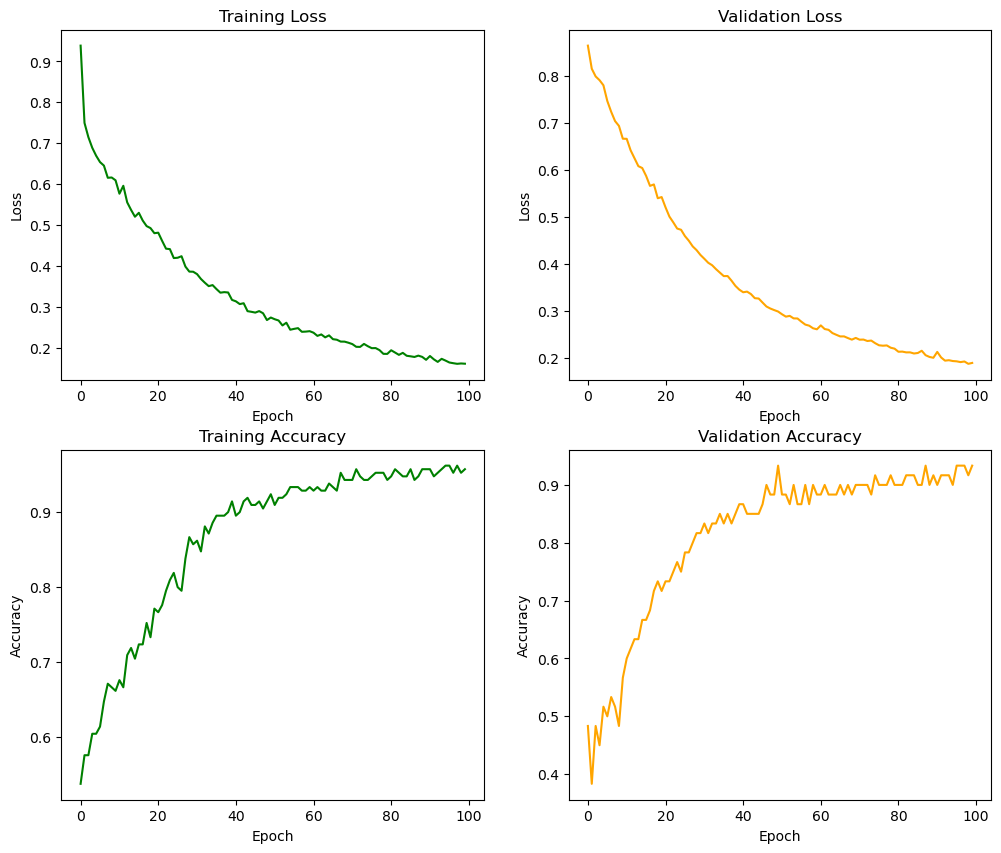

In [21]:
fig , ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0]. plot(train_losses , color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0]. set_title('Training Loss')

ax[0, 1]. plot(val_losses , color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1]. set_title('Validation Loss')

ax[1, 0]. plot(train_accs , color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0]. set_title('Training Accuracy')

ax[1, 1]. plot(val_accs , color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1]. set_title('Validation Accuracy')

In [22]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad ():
    for X_samples , y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict , test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')


Evaluation on test set:
Accuracy: 0.9333333333333333
